In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 한글폰트 설정 (실행 후 런타임 다시 시작하고 다시 실행하면 한글폰트 적용 가능) -> colab 기준, jupyter 사용시 문의바람
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [5]:
total_df = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/raw_data/W_total.csv')
total_df.head()

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6
0,0,20201231165209,렉스턴,21312de55841d2c624d4873b1f13d1f5,서울 영등포구 신길동1155,650000,1,0,101.0,101.0,101.0,101.0,102.0,101.0
1,1,20201231164930,K7,bb6a02da9253f463cbbdecf49352246a,대덕구 중리동 394-16,500000,1,0,85.0,85.0,NaN,85.0,87.0,NaN
2,2,20201231164557,투싼,f87010f9e1357101908204837a9f05fd,경남 창원시 성산구,500000,1,0,284.0,284.0,284.0,284.0,285.0,NaN
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN
4,4,20201231145042,QM6,5fb9e60a3686436567a032d93539f07c,인천광역시 부평구 부평북로,500000,1,0,284.0,284.0,NaN,284.0,285.0,NaN


In [31]:
# 차 이름 - 모델 매칭 테이블 불러오기
name = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/Preprocessing/all_cars(modified).csv')
name.head()

,Unnamed: 0,name,model,maker,prefix,postfix,kind
0,0,렉스턴,렉스턴,쌍용,0,0,['Mid-Large suv']
1,1,K7,K7,기아,0,0,['Sedan']
2,2,투싼,투싼,현대,0,0,['Mid-Large suv']
3,3,기아 4세대 카니발 KA4,카니발,기아,0,0,['van']
4,4,QM6,QM6,르노삼성,0,0,['Mid-Large suv']


In [32]:
# 차 이름 - 모델 매칭 테이블과 조인
total_df = total_df.merge(name[['name', 'model', 'maker']], left_on = 'car', right_on = 'name', how = 'left')
total_df.head()

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6,name,model,maker
0,0,20201231165209,렉스턴,21312de55841d2c624d4873b1f13d1f5,서울 영등포구 신길동1155,650000,1,0,101.0,101.0,101.0,101.0,102.0,101.0,렉스턴,렉스턴,쌍용
1,1,20201231164930,K7,bb6a02da9253f463cbbdecf49352246a,대덕구 중리동 394-16,500000,1,0,85.0,85.0,NaN,85.0,87.0,NaN,K7,K7,기아
2,2,20201231164557,투싼,f87010f9e1357101908204837a9f05fd,경남 창원시 성산구,500000,1,0,284.0,284.0,284.0,284.0,285.0,NaN,투싼,투싼,현대
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN,기아 4세대 카니발 KA4,카니발,기아
4,4,20201231145042,QM6,5fb9e60a3686436567a032d93539f07c,인천광역시 부평구 부평북로,500000,1,0,284.0,284.0,NaN,284.0,285.0,NaN,QM6,QM6,르노삼성


In [34]:
# 상품번호 - 상품명 매칭 테이블 가져오기 및 조인
product = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/raw_data/product.csv')
product = product.rename(columns = {'name' : 'product_name'})
total_df_item = total_df.copy()
for i in range(1, 7):
  total_df_item = total_df_item.merge(product[['product', 'product_name']], left_on = 'product_%d'%i, right_on = 'product', how = 'left')
  total_df_item = total_df_item.rename(columns = {'product_name' : 'product_%d_name' % i})
  total_df_item = total_df_item.drop(columns = ['product'])
total_df_item.head()

,Unnamed: 0,regist_dt,car,store,store_addr,price,pay_kind,by_dealer,product_1,product_2,product_3,product_4,product_5,product_6,name,model,maker,product_1_name,product_2_name,product_3_name,product_4_name,product_5_name,product_6_name
0,0,20201231165209,렉스턴,21312de55841d2c624d4873b1f13d1f5,서울 영등포구 신길동1155,650000,1,0,101.0,101.0,101.0,101.0,102.0,101.0,렉스턴,렉스턴,쌍용,Pinnacle,Pinnacle,Pinnacle,Pinnacle,Pinnacle,Pinnacle
1,1,20201231164930,K7,bb6a02da9253f463cbbdecf49352246a,대덕구 중리동 394-16,500000,1,0,85.0,85.0,NaN,85.0,87.0,NaN,K7,K7,기아,Star,Star,NaN,Star,Star,NaN
2,2,20201231164557,투싼,f87010f9e1357101908204837a9f05fd,경남 창원시 성산구,500000,1,0,284.0,284.0,284.0,284.0,285.0,NaN,투싼,투싼,현대,Super,Super,Super,Super,Super,NaN
3,3,20201231154431,기아 4세대 카니발 KA4,3b1de9448312d7ae5811d04787b27fb9,전북 익산시 어곳2길,700000,2,0,84.0,84.0,NaN,84.0,87.0,NaN,기아 4세대 카니발 KA4,카니발,기아,Star,Star,NaN,Star,Star,NaN
4,4,20201231145042,QM6,5fb9e60a3686436567a032d93539f07c,인천광역시 부평구 부평북로,500000,1,0,284.0,284.0,NaN,284.0,285.0,NaN,QM6,QM6,르노삼성,Super,Super,NaN,Super,Super,NaN


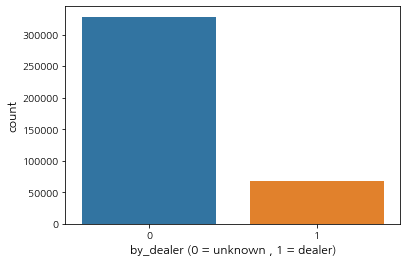

In [35]:
import seaborn as sns

# 328315 vs 67574 (전체 수 파악)

total_df_item['by_dealer'] = total_df_item['by_dealer'].astype(str)
dealer_count = total_df_item['by_dealer'].value_counts()
sns.barplot(x = dealer_count.index, y = dealer_count)

plt.xlabel('by_dealer (0 = unknown , 1 = dealer)', size = 12)
plt.ylabel('count', size = 12)
plt.show()

In [37]:
## 브랜드 별 딜러 차이 파악

# 딜러 유무에 따라 데이터프레임 나누는 과정
no_dealer = total_df_item.loc[total_df_item['by_dealer'] == '0']
yes_dealer = total_df_item.loc[total_df_item['by_dealer'] == '1']

# 딜러 유무에 따라 각 브랜드의 차지 비율을 계산
no_top_brand = no_dealer.loc[no_dealer['maker'] != '0','maker'].value_counts().head(15) / (no_dealer.loc[no_dealer['maker'] != '0','maker'].shape[0] / 100) # 이상치 제거
yes_top_brand = yes_dealer['maker'].value_counts().head(15) / (yes_dealer.shape[0] / 100)

dealer_result_b = pd.concat([pd.DataFrame(no_top_brand), pd.DataFrame(yes_top_brand)], axis = 1)
dealer_result_b = dealer_result_b.dropna()
dealer_result_b.columns = {'dealer = 0', 'dealer = 1'}
dealer_result_b

,dealer = 0,dealer = 1
현대,44.360521,46.622961
기아,28.572439,33.045254
르노삼성,5.459804,7.514725
쌍용,4.954620,3.385918
쉐보레/한국GM,3.692890,3.914227
벤츠,3.105559,1.379229
BMW,1.664154,0.591944
제네시스,1.416792,1.611567
토요타,1.338338,0.103590
아우디,0.600560,0.137627


In [38]:
## 차종 별 딜러 차이 파악

no_top_model = no_dealer['model'].value_counts().head(15) / (no_dealer.shape[0] / 100)
yes_top_model = yes_dealer['model'].value_counts().head(15) / (yes_dealer.shape[0] / 100)

dealer_result_m = pd.concat([pd.DataFrame(no_top_model), pd.DataFrame(yes_top_model)], axis = 1)
dealer_result_m = dealer_result_m.dropna()
dealer_result_m.columns = {'dealer = 0', 'dealer = 1'}
dealer_result_m

,dealer = 0,dealer = 1
그랜저,10.384539,10.817770
싼타페,7.006686,5.700417
제네시스,5.804182,5.126232
쏘렌토,4.994289,5.428123
쏘나타,4.364711,5.006363
아반떼,4.311104,5.395566
카니발,3.824376,3.311925
K5,3.340694,4.682274
K7,3.315109,3.813597
팰리세이드,3.001690,4.259035


In [40]:
## 딜러 유무에 따라 각 아이템 별로 차지하는 비율 살피기

# 상대적으로 많이 팔린 아이템 목록
best_item = ['Latitude', 'Artisan', 'Vertex 700', 'Vertex 900', 'Star', 'Super', 'Vertex 500', 'Bisanti', 'TNT', 'Pinnacle', 'Pro']

# 아이템 위치 설정 (1 ~ 6)
i = 1

# 딜러 유무에 따라 각 아이템이 차지하는 비율 산출
no_count = no_dealer['product_%d_name'%i].value_counts()
yes_count = yes_dealer['product_%d_name'%i].value_counts()
no_top_item_1 = no_count.loc[no_count.index.isin(best_item)] / (no_dealer['product_%d_name'%i].dropna().shape[0] / 100)
yes_top_item_1 = yes_count.loc[yes_count.index.isin(best_item)] / (yes_dealer['product_%d_name'%i].dropna().shape[0] / 100)

dealer_result_1 = pd.concat([pd.DataFrame(no_top_item_1), pd.DataFrame(yes_top_item_1)], axis = 1)
dealer_result_1 = dealer_result_1.dropna()
dealer_result_1.columns = {'dealer = 0', 'dealer = 1'}
dealer_result_1

,dealer = 0,dealer = 1
Artisan,32.161059,26.549820
Star,13.392577,3.689476
Latitude,12.610510,9.983193
Super,12.147458,35.241297
Vertex 700,9.635825,6.617047
Vertex 900,4.612939,2.252101
Vertex 500,3.830490,4.363345
TNT,2.568178,5.672669
Pro,2.127668,0.771509
Pinnacle,1.773502,0.291317


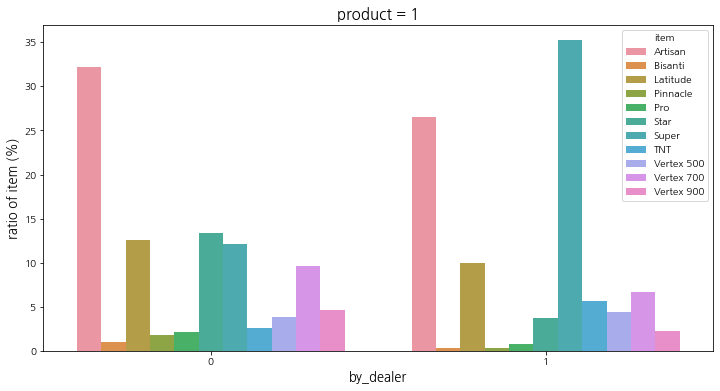

In [41]:
## 딜러 유무에 따라 각 아이템의 차지 비율 시각화

# 아이템 위치 설정 (1 ~ 6)
i = 1

# 아이템 차지 비율 전처리 (앞 코드와 동일)
no_count = no_dealer['product_%d_name'%i].value_counts()
yes_count = yes_dealer['product_%d_name'%i].value_counts()
no_top_item = no_count.loc[no_count.index.isin(best_item)] / (no_dealer['product_%d_name'%i].dropna().shape[0] / 100)
yes_top_item = yes_count.loc[yes_count.index.isin(best_item)] / (yes_dealer['product_%d_name'%i].dropna().shape[0] / 100)

# seaborn에서 단번에 시각화가 될 수 있도록 전처리
dealer_result = pd.concat([pd.DataFrame(no_top_item), pd.DataFrame(yes_top_item)], axis = 1)
dealer_result = dealer_result.dropna()
dealer_result.columns = {'dealer = 0', 'dealer = 1'}

dealer_result = dealer_result.reset_index()
dealer_result = dealer_result.rename(columns = {'index' : 'item'})

item_concat = pd.concat([dealer_result[['item', 'dealer = 0']].rename(columns = {'dealer = 0' : 'ratio'}), dealer_result[['item', 'dealer = 1']].rename(columns = {'dealer = 1' : 'ratio'})])
item_concat = item_concat.reset_index(drop = True)
item_concat['by_dealer'] = pd.Series(['0'] * len(best_item) + ['1'] * len(best_item))

item_concat = item_concat.sort_values(by = 'item')

# 최종 시각화
plt.figure(figsize = (12, 6))
sns.barplot(x = 'by_dealer', y = 'ratio', hue = 'item', data = item_concat)
plt.xlabel('by_dealer', size = 13)
plt.ylabel('ratio of item (%)', size = 13)
plt.title('product = %d' %i, size = 15)
plt.show()

In [43]:
# 참고 : 위 시각화에서 사용된 데이터프레임
item_concat.head()

,item,ratio,by_dealer
0,Artisan,32.161059,0
11,Artisan,26.549820,1
10,Bisanti,0.962780,0
21,Bisanti,0.320128,1
13,Latitude,9.983193,1


std : 126149 vs 99749


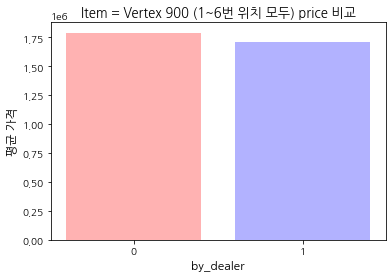

In [50]:
## 1 ~ 6번 위치가 모두 같은 아이템 종류도 시공된 경우에 대해서 시각화

# 아이템 이름 입력
item = 'Vertex 900'

# 조건에 맞는 행들만 가져와 가격 정보 추출
all_item = total_df_item.loc[(total_df_item['product_1_name'] == item) & (total_df_item['product_2_name'] == item)  & (total_df_item['product_3_name'] == item)  & \
                  (total_df_item['product_4_name'] == item)  & (total_df_item['product_5_name'] == item)  & (total_df_item['product_6_name'] == item)]
all_item_0 = all_item.loc[all_item['by_dealer'] == '0', 'price']
all_item_1 = all_item.loc[all_item['by_dealer'] == '1', 'price']

# 최종 시각화
plt.bar(['0', '1'] , [all_item_0.mean(), all_item_1.mean()], color = ['r', 'b'], alpha = 0.3)
plt.title('Item = %s (1~6번 위치 모두) price 비교' % item, size = 13)
plt.xlabel('by_dealer', size = 12)
plt.ylabel('평균 가격', size = 12)

# 표준편차 출력
print('std : %d vs %d' % (all_item_0.std(), all_item_1.std()))